# Convolutional MNIST

En este notebook de ejercicios, vamos a mejorar el modelo que usamos para MNIST. La mejora consistirá en agregar primeramente más *layers* al modelo. Luego, un segundo modelo que use un *layer* de convolución. Finalmente, vamos a comparar la calidad de los dos modelos durante el entrenamiento y la evaluación.

Por conveniencia, se incluye gran parte del código, además de funciones para visualizar mejor la evaluación de los modelos.

**Importante**: Antes de correr el código en este notebook, elija un nuevo tipo de *Runtime*:
1. Haga click en *Runtime* en el menú de arriba.
2. *Change runtime type*
3. Elija *GPU*
4. Click en *SAVE*

Esto reiniciará el *runtime* y será considerablemente más rápido el entrenamiento de los modelos convolucionales.

Primeramente, se incluyen las bibliotecas necesarias.

In [1]:
%tensorflow_version 2.x
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
plt.style.use('default')

TensorFlow 2.x selected.


# Funciones de ayuda

en la siguiente celda, se proveen varias funciones que servirán para entender las diferencias entre los modelos y comparar su rendimiento. Como en casos anteriores, es recomendable que al terminar los ejercicios se estudie este código para entender cómo monitorear el rendimiento.

In [ ]:
def ver_historia(historia, titulo = '', ax = None):
    """
    Visualizar una la historia de un modelo, 
    se hará una figura que muestre la evolución de la
    función de costo y de la precisión del modelo con
    respecto a los epochs.

    Parameters
    ----------
    historia : keras History
        Es lo que retorna la llamada a `model.fit`
    titulo : str
        el título del ax de arriba
    ax : np.array
        si se provee, no se creará una imagen nueva y se usará
        `ax` en su lugar. Se debe proveer 2 ejes de una figura
        de pyplot.
    """
    create = ax is None
    if create:
        fig, ax = plt.subplots(2,1,figsize=(10,8), dpi=100)
    acc      = historia.history['accuracy']
    val_acc  = historia.history['val_accuracy']
    loss     = historia.history['loss']
    val_loss = historia.history['val_loss']
    epochs = range(len(acc))
    ax[0].grid(True)
    ax[0].plot(epochs, acc, label=f"Entrenamiento - {titulo}")
    ax[0].plot(epochs, val_acc, label=f"Evaluación - {titulo}")
    ax[0].set_ylabel('Precisión')
    ax[0].set_xlabel('Epoch')
    ax[0].legend()
    ax[1].grid(True)
    ax[1].plot(epochs, loss, label=f"Entrenamiento - {titulo}")
    ax[1].plot(epochs, val_loss, label=f"Evaluación - {titulo}")
    ax[1].set_ylabel('Costo')
    ax[1].set_xlabel('Epoch')
    ax[1].legend()
    if create:
        plt.show()


# Ejercicio 1 - Carga y normalización del dataset

Por conveniencia, se carga el *dataset* en variables de entrenamiento que se usarán más adelante.
En este ejercicio, simplemente tienes que normalizar estas variables.

In [3]:
(train_imgs, train_labels), (test_imgs, test_labels) = tf.keras.datasets.mnist.load_data()
# normalizar las imágenes de entrenamiento y testing 
# tu código aquí (~2 líneas)
train_imgs = train_imgs / 255.0
test_imgs = test_imgs / 255.0

11493376/11490434 [==============================] - 0s 0us/step


# Ejercicio 1 - Recrear el modelo de MNIST

En la siguiente celda, completa el código necesario para recrear el modelo. 

La línea de entrenamiento del modelo ya se provee. Esto es porque para monitorear el rendimiento del modelo, vamos a analizar el historial de valores de las funciones de pérdida y la métrica de precisión en cada *epoch*. la llamada a `model.fit` retorna este historial. Para poder medir el historial de validación, también le pasamos el *validation set* a `model.fit`, de esta manera, el entrenamiento y la evaluación se hacen al mismo momento y en una sola llamada. Si lo desea, puede agregar más *layers* a su modelo, y ver como esto impacta en el rendimiento del modelo.

In [4]:
# crear el modelo
model = tf.keras.models.Sequential([tf.keras.layers.Flatten(input_shape=(28, 28)), # tu código aquí (~3-8 líneas)
                                    tf.keras.layers.Dense(100, activation='relu'), 
                                    tf.keras.layers.Dense(10, activation='softmax')])

# compilar el modelo
# tu código aquí (~1 línea)
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# entrenar el modelo
historia = model.fit(train_imgs, train_labels, validation_data=(test_imgs, test_labels), epochs=10)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 7s 109us/sample - loss: 0.6556 - accuracy: 0.8362 - val_loss: 0.3617 - val_accuracy: 0.9028
Epoch 2/10
60000/60000 [==============================] - 5s 78us/sample - loss: 0.3421 - accuracy: 0.9053 - val_loss: 0.2988 - val_accuracy: 0.9154
Epoch 3/10
60000/60000 [==============================] - 5s 77us/sample - loss: 0.2946 - accuracy: 0.9169 - val_loss: 0.2690 - val_accuracy: 0.9243
Epoch 4/10
60000/60000 [==============================] - 5s 75us/sample - loss: 0.2653 - accuracy: 0.9261 - val_loss: 0.2469 - val_accuracy: 0.9305
Epoch 5/10
60000/60000 [==============================] - 4s 74us/sample - loss: 0.2429 - accuracy: 0.9317 - val_loss: 0.2279 - val_accuracy: 0.9360
Epoch 6/10
60000/60000 [==============================] - 4s 73us/sample - loss: 0.2245 - accuracy: 0.9365 - val_loss: 0.2124 - val_accuracy: 0.9404
Epoch 7/10
60000/60000 [==============================]

Con el modelo entrenado, podemos visualizar el historial.

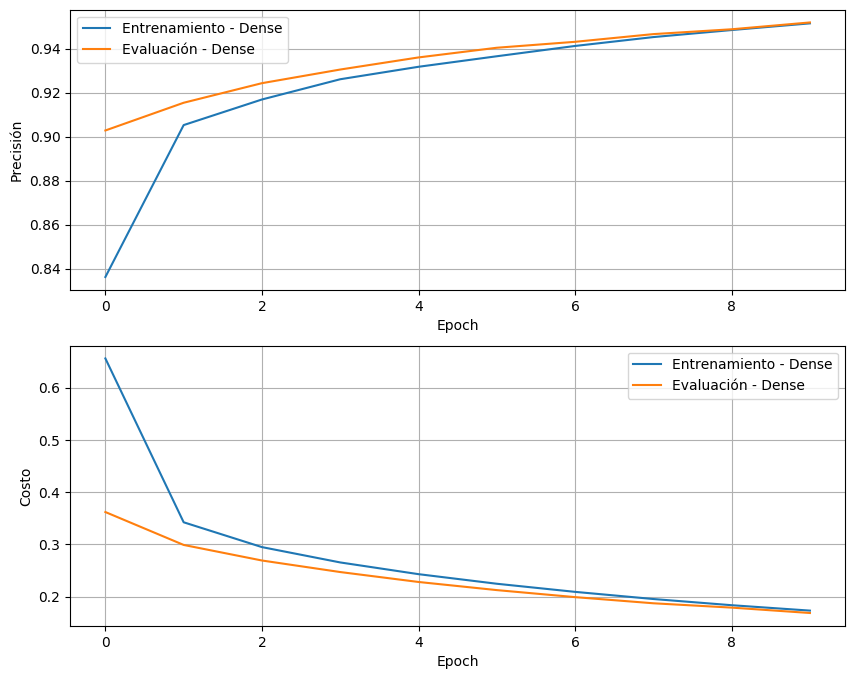

In [5]:
ver_historia(historia, titulo='Dense')

Hay que prestar atención a este historial. Note como el rendimiento durante el entrenamiento es considerablemente mejor que el rendimiento en la evaluación. Esto es normal, y es una de las evidencias del *overfitting*. Estamos aprendiendo a clasificar imágenes casi exclusivamente para el *training set*. Visualizar el rendimiento de esta manera nos ayuda a tomar una decisión razonable de cuando parar el entrenamiento para evitar el overfitting. Luego de terminar los siguientes ejercicios, pruebe incrementar el valor de `epochs` y analice con cuidado el historial de comportamiento.

# Ejercicio 2 - crear un segundo modelo

Es momento de agregar *layers* convolucionales a nuestro modelo. En la siguiente celda, cree un nuevo modelo en la variable `cnn_model` que tenga uno o más *layers* convolucionales. No elimine los *layers* que se proveen, pues ayudan para lidiar con el cambio de dimensionalidad de los datos. Inserte los *layers* convolucionales donde se indica.

## El *layer* convolucional

Un ejemplo de *layer* convolucional es el siguiente:

```python
tf.keras.layers.Conv2D(32, (3, 3), activation='relu')
```
esto indica un *layer* de 32 neuronas, con filtros de 3x3. 

Si lo desea, puede agregar *pooling layers* a su modelo. Es común intercalar *layers* convolucionales con pooling layers. Un ejemplo es el siguiente:

```python
tf.keras.layers.MaxPooling2D(2, 2)
```

esto indica que ese layer va a reducir la resolución de la imagen a la mitad. Estudie la diferencia de agregar el pooling en el tiempo de entrenamiento y diferencia de rendimiento.

**Importante**: Los *layers* convolucionales son computacionalmente más costosos de entrenar, por lo que no agregue más de 5 *layers* convolucionales o el entrenamiento puede ser de hasta media hora!



In [6]:
# crear el modelo
model2 = tf.keras.models.Sequential([tf.keras.layers.Reshape(input_shape=(28, 28), target_shape=(28, 28, 1)), 
                                     # tu código aquí (~3-8 líneas)
                                    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
                                    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
                                    tf.keras.layers.Conv2D(33, (3, 3), activation='relu'),
                                    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(128, activation='relu'), 
                                    tf.keras.layers.Dense(10, activation='softmax')])

# compilar el modelo
# tu código aquí (~1 línea)
model2.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# entrenar el modelo
historia2 = model2.fit(train_imgs, train_labels, validation_data=(test_imgs, test_labels), epochs=10, batch_size=100)# su código aquí (~1 línea)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 15s 258us/sample - loss: 0.7470 - accuracy: 0.8020 - val_loss: 0.2036 - val_accuracy: 0.9396
Epoch 2/10
60000/60000 [==============================] - 10s 163us/sample - loss: 0.1933 - accuracy: 0.9428 - val_loss: 0.1584 - val_accuracy: 0.9518
Epoch 3/10
60000/60000 [==============================] - 10s 165us/sample - loss: 0.1353 - accuracy: 0.9598 - val_loss: 0.1174 - val_accuracy: 0.9646
Epoch 4/10
60000/60000 [==============================] - 10s 165us/sample - loss: 0.1025 - accuracy: 0.9697 - val_loss: 0.0894 - val_accuracy: 0.9718
Epoch 5/10
60000/60000 [==============================] - 10s 164us/sample - loss: 0.0824 - accuracy: 0.9750 - val_loss: 0.0749 - val_accuracy: 0.9774
Epoch 6/10
60000/60000 [==============================] - 10s 167us/sample - loss: 0.0668 - accuracy: 0.9801 - val_loss: 0.0748 - val_accuracy: 0.9776
Epoch 7/10
60000/60000 [====================

Ahora podemos analizar y comparar ambas historias.

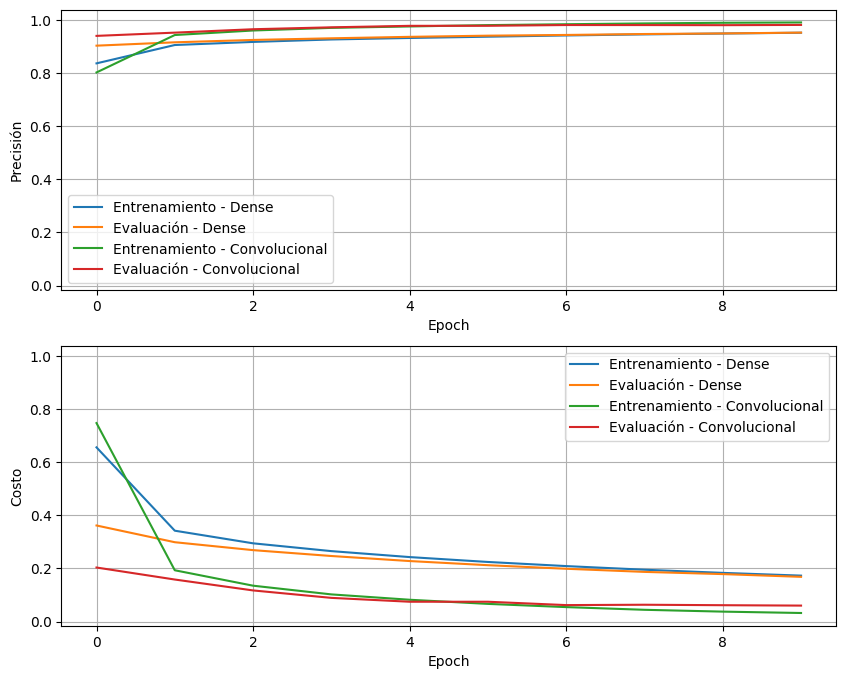

In [7]:
fig, axs = plt.subplots(2,1, figsize=(10, 8), dpi=100, sharey=True)
ver_historia(historia, 'Dense', ax=axs)
ver_historia(historia2, 'Convolucional', ax=axs)
plt.show()

Como es esperado, vemos que el rendimiento del modelo convolucional mejora el rendimiento de forma considerable.

# Visualizar los *layers* convolucionales.

A partir de este punto, ya no hay ejercicios en este notebook, pero puedes explorar que tipo de *features* son extraidos por los diferentes *layers* convolucionales. 

Puedes ejecutar varias veces esta celda para ver diversas imágenes y diversos filtros convolucionales aplicados. No es simple determinar con exactitud cuál de los filtros es el responsable de la mejora en performance de la red neuronal, y explicar el "razonamiento" de una red neuronal es un tema activo de investigación.

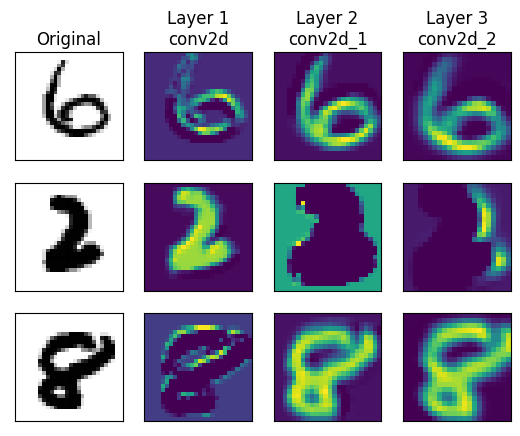

In [22]:
f, axarr = plt.subplots(3,4)
imagenes=np.random.choice(len(test_imgs), 3)
layer_outputs = [layer.output for layer in model2.layers]
activation_model = tf.keras.models.Model(inputs = model2.input, outputs = layer_outputs)
for x in range(0,4):
    if x == 0:
        axarr[0,x].imshow(test_imgs[imagenes[0]], cmap='gray_r')
        axarr[0,x].set(title='Original')
        axarr[1,x].imshow(test_imgs[imagenes[1]], cmap='gray_r')
        axarr[2,x].imshow(test_imgs[imagenes[2]], cmap='gray_r')
    else:
        f1 = activation_model.predict(test_imgs[imagenes[0]].reshape(1, 28, 28))[x]
        name = layer_outputs[x].name.split('/')[0]
        conv = np.random.choice(f1.shape[-1])
        axarr[0,x].imshow(f1[0, : , :, conv])
        axarr[0,x].set(title=f'Layer {x}\n{name}')
        f2 = activation_model.predict(test_imgs[imagenes[1]].reshape(1, 28, 28))[x]
        conv = np.random.choice(f2.shape[-1])
        axarr[1,x].imshow(f2[0, : , :, conv])
        f3 = activation_model.predict(test_imgs[imagenes[2]].reshape(1, 28, 28))[x]
        conv = np.random.choice(f3.shape[-1])
        axarr[2,x].imshow(f3[0, : , :, conv])
    for i in range(3):
        axarr[i,x].grid(False)
        axarr[i,x].get_xaxis().set_ticks([])
        axarr[i,x].get_yaxis().set_ticks([])
        

# Créditos

Este notebook utiliza y modifica recursos del [tutorial de TensorFlow](https://www.tensorflow.org/tutorials/images/cnn) y está inspirado en contenido del curso online [TensorFlow in Practice](https://www.deeplearning.ai/tensorflow-in-practice/).